# Perform Uncertainty analysis on gauge height data

## Here is an implementation of LSTM with data 'sub-selection' as an uncertainty estimation method. For futher information refer (https://www.mdpi.com/2073-4441/12/3/884)

### Data was obtained from USGS waterdata (https://waterdata.usgs.gov/usa/nwis/uv?07019130)


In [13]:
# import all the required libraries

import numpy
import numpy as np
import pandas as pd
import random
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from keras.layers.core import Lambda
from keras import backend as K
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM

In [14]:
# Import Water levels data in Valley Park, MO on the Meramac river
df = pd.read_excel ('Valleypark.xlsx')

# Selecting the values after 1996 as they have 15 min recordings
df = df[:-143441]  

# Convert string data to float
df = df.astype(float) 

# Removing NAN values
data = x = np.array(df)[~numpy.isnan(np.array(df))]
data = pd.DataFrame(data)
    
# Normalizing data
data = numpy.reshape(data, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [15]:
# Create the experiment

def experiment(train,test):
    
    train = np.array(train)
    total_data = np.concatenate((train,test))
    
    
    
    # Function for creating lookback data
    def create_dataset(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            X.append(a)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    

    # Defining lookback to create training and testing data for LSTM
    look_back = 20
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)
    
    
    
    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    
    
    # LSTM model with 1 LSTM unit, Dropout layer and Dense Layer
    model = Sequential()
    model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse']) 
    
    
    history = model.fit(X_train, Y_train, epochs=2, batch_size=1000, validation_split=0.33,
                    verbose=1, shuffle=False)
    model.summary()
    
    
    
    # Predictions from the model
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform([Y_test])
    
    
    
    # Save the model for future use
    from keras.models import model_from_json
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model.h5")
    
    
    
    # Print performance metrics for each epoch
    print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
    print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
    print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
    print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
    
    
    
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(total_data)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(total_data)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(total_data)-1, :] = test_predict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(total_data))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    
    
    # Store performance metrics
    acc= []
    acc.append(mean_absolute_error(Y_train[0], train_predict[:,0]))
    acc.append(np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
    acc.append(mean_absolute_error(Y_test[0], test_predict[:,0]))
    acc.append(np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
    
    
    
    # Create input sample for out-of-sample predictions
    newtest = X_test
    newtest = np.split(newtest, len(newtest))
    sample = newtest[len(newtest) - 1]
    
    
    
    # Make new predictions -- > 584 new samples predicted in this scenario 
    no_predictions = 584
    
    data_results = []
    
    for x in range(no_predictions):
        pred = model.predict(sample)
        sample = np.delete(sample, 0, axis=2)
        sample = np.append(sample, pred)
        sample = np.array([[list(sample)]])
        scaler.inverse_transform(pred)
        data_results.append(pred)
        
    data_results = numpy.concatenate( data_results, axis=0 )
    data_results = scaler.inverse_transform(data_results)
    
    
    
    # Return the test, out-of sample predictions and performance metrics
    return test_predict,data_results, acc

### Sub-selection

For a data sample = [1,1,2,2,3,4]

Sub-selected data samples can be,
- [2,2,3,4]
- [1,2,2,3,4]
- [2,3,4]

Varaition occurs only in the first part keeping the rest of the series same for the multiple iterations.

iteration
0
Train on 54456 samples, validate on 26822 samples
Epoch 1/2
54456/54456 [==============================] - 3s 47us/step - loss: 0.0174 - mean_absolute_error: 0.0854 - mean_squared_error: 0.0174 - val_loss: 0.0019 - val_mean_absolute_error: 0.0418 - val_mean_squared_error: 0.0019
Epoch 2/2
54456/54456 [==============================] - 1s 10us/step - loss: 7.4889e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 7.4889e-04 - val_loss: 4.4122e-04 - val_mean_absolute_error: 0.0194 - val_mean_squared_error: 4.4122e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
________________________________________________________________

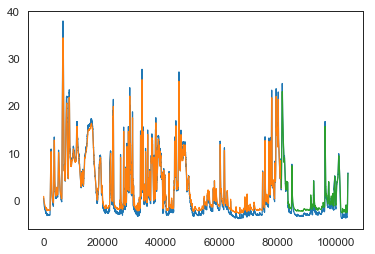

iteration
1
Train on 35362 samples, validate on 17418 samples
Epoch 1/2
35362/35362 [==============================] - 3s 77us/step - loss: 0.0129 - mean_absolute_error: 0.0773 - mean_squared_error: 0.0129 - val_loss: 0.0024 - val_mean_absolute_error: 0.0482 - val_mean_squared_error: 0.0024
Epoch 2/2
35362/35362 [==============================] - 0s 13us/step - loss: 8.9066e-04 - mean_absolute_error: 0.0238 - mean_squared_error: 8.9066e-04 - val_loss: 5.2765e-04 - val_mean_absolute_error: 0.0170 - val_mean_squared_error: 5.2765e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
________________________________________________________________

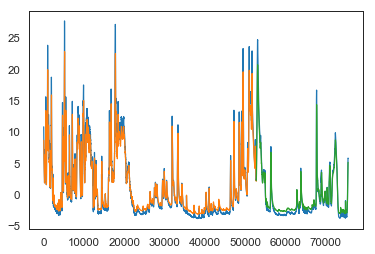

iteration
2
Train on 23145 samples, validate on 11401 samples
Epoch 1/2
23145/23145 [==============================] - 3s 132us/step - loss: 0.0198 - mean_absolute_error: 0.0801 - mean_squared_error: 0.0198 - val_loss: 0.0223 - val_mean_absolute_error: 0.0933 - val_mean_squared_error: 0.0223
Epoch 2/2
23145/23145 [==============================] - 0s 11us/step - loss: 0.0069 - mean_absolute_error: 0.0505 - mean_squared_error: 0.0069 - val_loss: 0.0074 - val_mean_absolute_error: 0.0602 - val_mean_squared_error: 0.0074
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
_________________________________________________________________
Train Mean Ab

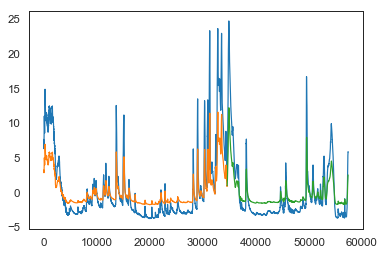

iteration
3
Train on 25129 samples, validate on 12377 samples
Epoch 1/2
25129/25129 [==============================] - 3s 122us/step - loss: 0.0206 - mean_absolute_error: 0.0817 - mean_squared_error: 0.0206 - val_loss: 0.0093 - val_mean_absolute_error: 0.0622 - val_mean_squared_error: 0.0093
Epoch 2/2
25129/25129 [==============================] - 0s 16us/step - loss: 0.0046 - mean_absolute_error: 0.0489 - mean_squared_error: 0.0046 - val_loss: 0.0019 - val_mean_absolute_error: 0.0367 - val_mean_squared_error: 0.0019
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
_________________________________________________________________
Train Mean Ab

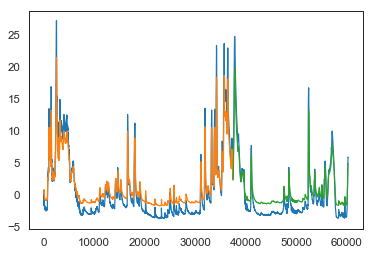

iteration
4
Train on 26819 samples, validate on 13210 samples
Epoch 1/2
26819/26819 [==============================] - 3s 111us/step - loss: 0.0145 - mean_absolute_error: 0.0704 - mean_squared_error: 0.0145 - val_loss: 0.0041 - val_mean_absolute_error: 0.0462 - val_mean_squared_error: 0.0041
Epoch 2/2
26819/26819 [==============================] - 0s 9us/step - loss: 0.0021 - mean_absolute_error: 0.0383 - mean_squared_error: 0.0021 - val_loss: 0.0011 - val_mean_absolute_error: 0.0297 - val_mean_squared_error: 0.0011
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
_________________________________________________________________
Train Mean Abs

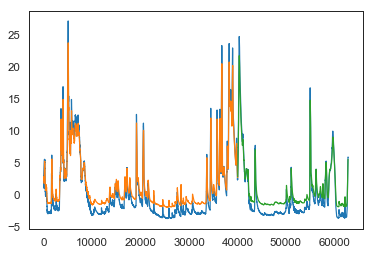

iteration
5
Train on 57585 samples, validate on 28363 samples
Epoch 1/2
57585/57585 [==============================] - 4s 65us/step - loss: 0.0072 - mean_absolute_error: 0.0591 - mean_squared_error: 0.0072 - val_loss: 6.9811e-04 - val_mean_absolute_error: 0.0246 - val_mean_squared_error: 6.9811e-04
Epoch 2/2
57585/57585 [==============================] - 1s 17us/step - loss: 6.5816e-04 - mean_absolute_error: 0.0176 - mean_squared_error: 6.5816e-04 - val_loss: 1.0962e-04 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 1.0962e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
________________________________________________________

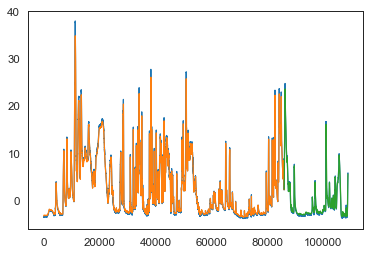

iteration
6
Train on 49155 samples, validate on 24212 samples
Epoch 1/2
49155/49155 [==============================] - 4s 84us/step - loss: 0.0188 - mean_absolute_error: 0.0833 - mean_squared_error: 0.0188 - val_loss: 0.0015 - val_mean_absolute_error: 0.0376 - val_mean_squared_error: 0.0015
Epoch 2/2
49155/49155 [==============================] - 0s 10us/step - loss: 5.5399e-04 - mean_absolute_error: 0.0201 - mean_squared_error: 5.5399e-04 - val_loss: 4.6130e-04 - val_mean_absolute_error: 0.0199 - val_mean_squared_error: 4.6130e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 40)                9760      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
________________________________________________________________

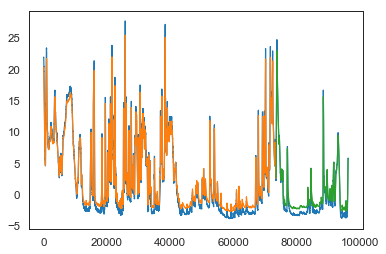

iteration
7
Train on 55178 samples, validate on 27178 samples
Epoch 1/2
55178/55178 [==============================] - 4s 69us/step - loss: 0.0194 - mean_absolute_error: 0.0909 - mean_squared_error: 0.0194 - val_loss: 0.0024 - val_mean_absolute_error: 0.0468 - val_mean_squared_error: 0.0024
Epoch 2/2
55178/55178 [==============================] - 1s 11us/step - loss: 0.0010 - mean_absolute_error: 0.0259 - mean_squared_error: 0.0010 - val_loss: 5.2012e-04 - val_mean_absolute_error: 0.0211 - val_mean_squared_error: 5.2012e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 40)                9760      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
_________________________________________________________________
Train 

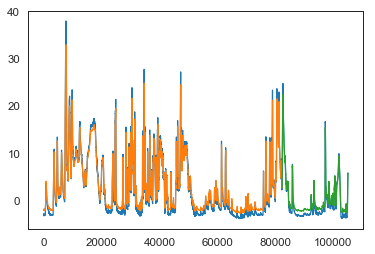

iteration
8
Train on 38602 samples, validate on 19013 samples
Epoch 1/2
38602/38602 [==============================] - 7s 174us/step - loss: 0.0064 - mean_absolute_error: 0.0535 - mean_squared_error: 0.0064 - val_loss: 0.0014 - val_mean_absolute_error: 0.0364 - val_mean_squared_error: 0.0014
Epoch 2/2
38602/38602 [==============================] - 0s 11us/step - loss: 4.4458e-04 - mean_absolute_error: 0.0167 - mean_squared_error: 4.4458e-04 - val_loss: 1.6572e-04 - val_mean_absolute_error: 0.0109 - val_mean_squared_error: 1.6572e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 40)                9760      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
_______________________________________________________________

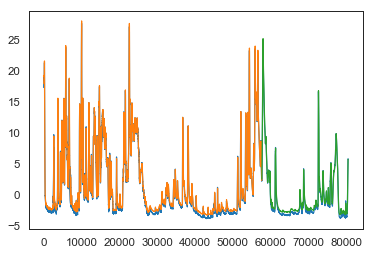

iteration
9
Train on 26942 samples, validate on 13271 samples
Epoch 1/2
26942/26942 [==============================] - 4s 146us/step - loss: 0.0100 - mean_absolute_error: 0.0598 - mean_squared_error: 0.0100 - val_loss: 0.0021 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0021
Epoch 2/2
26942/26942 [==============================] - 0s 11us/step - loss: 0.0012 - mean_absolute_error: 0.0303 - mean_squared_error: 0.0012 - val_loss: 6.5931e-04 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 6.5931e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 40)                9760      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 41        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
_________________________________________________________________
Train

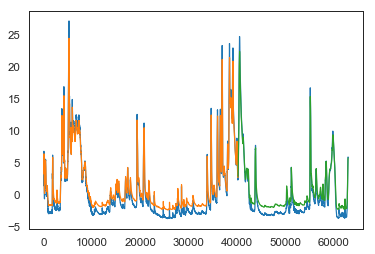

In [16]:
random.seed(1)
iters = 10

test_results = []
pred_results = []
acc_results = []


for x in range(iters):
    print('iteration')
    print(x)
    
    
    # Select the range of data (up,low) for the choice of sub-selection
    up = int(len(data)/2)
    low = int(len(data)/100)
    
    
    # Split data into testing and training data
    train_size = int(len(data) * 0.80)
    test_size = len(data) - train_size
    train, test = data[0:train_size, :], data[train_size:len(data), :]
    
    # Randomly sub-select a different traing sample
    val = random.randrange(low,up)
    train = train[val:] 

    test, pred, acc = experiment(train,test)
    
    test_results.append(test)
    pred_results.append(pred)
    acc_results.append(acc)

In [26]:
# Save out of sample predictions

import xlsxwriter

workbook = xlsxwriter.Workbook('data_uncertainty_prediction.xlsx')
worksheet = workbook.add_worksheet()


col = 0
for row in range(len(pred_results)):
    for col in range(len(pred_results[row])):
        value = pred_results[row][col][0]
        worksheet.write(col, row,value)
        
workbook.close()

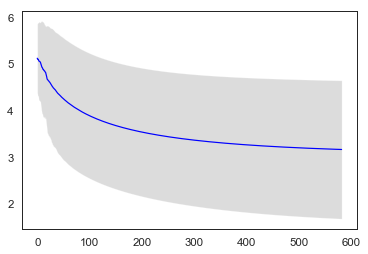

In [27]:
# Plot the uncertainty area

import scipy.stats as st

df2 = pd.read_excel ('data_uncertainty_prediction.xlsx')
df2 = df2.astype(float)   # Convert string data to float
data2 = df2

res = []
means = []
data2 = data2.T

cols = list(data2.columns) 
for x in range(len(cols)):
    means.append(data2[x].mean())
    res.append(st.t.interval(0.95, len(data2[x])-1, loc=np.mean(data2[x]), scale=st.sem(data2[x])))

low,high = map(list, zip(*res))

fig, ax = plt.subplots()

y = list(range(len(high)))
ax.fill_between(y, high,low, facecolor='grey', alpha=0.27 )
ax.plot(y,means,color = 'blue', label=' uncertainity (noise)')

plt.show()